In [1]:
from src.prepare_mimic_iii import transform_data
from src.call_aoai import call_aoai
from src.tree import TaxonomyParser
import pandas as pd
import ast
import functools

https://medcode-aoai-useast.openai.azure.com/


### Data Prep

In [2]:
# df = transform_data("data/") # Only re-run if change in preparation logic
df = pd.read_csv("data/joined/dataset_single_001_279.csv.gz")
print(df.shape)
display(df.head(5))

(7648, 3)


,HADM_ID,TEXT,ICD9_CODE
0,100003,['Chief Complaint: HPI: 24 Hour Events: awaiti...,[70]
1,100009,['2162-5-20 2:57 PM CHEST (PA & LAT) Clip # Cl...,"[272, 250, 278]"
2,100018,['Admission Date: 2176-8-29 Discharge Date: 21...,"[225, 250, 276, 278]"
3,100041,['2140-12-9 9:27 AM CHEST (PORTABLE AP) Clip #...,"[274, 244]"
4,100046,['2183-10-23 5:31 AM CHEST (SINGLE VIEW) Clip ...,"[275, 276]"


In [3]:
max_code = 75
slim_df = df[df['ICD9_CODE'].apply(lambda x: all(i < max_code for i in ast.literal_eval(x)))]
display(slim_df.head())

,HADM_ID,TEXT,ICD9_CODE
0,100003,['Chief Complaint: HPI: 24 Hour Events: awaiti...,[70]
6,100074,['Admission Date: 2176-4-9 Discharge Date: 217...,"[70, 38]"
10,100104,['Admission Date: 2201-6-21 Discharge Date: 22...,[38]
21,100307,['2161-10-29 3:35 PM ILIAC Clip # Clip Number ...,[41]
35,100498,['Admission Date: 2120-3-10 Discharge Date: 21...,[41]


In [31]:
# Initialize Code Tree
code_tree = TaxonomyParser()
code_tree.read_from_json("icd9_tax.json")

print(code_tree.find_by_name("0"))

Node('/root/0', description='Infectious and Parasitic Diseases')


In [35]:
code_tree.visualize("00")
code_tree.get_children("00")

00       Intestinal infectious diseases
├── 001  Cholera
├── 002  Typhoid and paratyphoid fevers
├── 003  Salmonella
├── 004  Shigellosis
├── 005  Other poisoning (bacterial)
├── 006  Amebiasis
├── 007  Other protozoal intestinal diseases
├── 008  Intestinal infections due to other organisms
└── 009  Ill-defined intestinal infections


(Node('/root/0/00/001', description='Cholera'),
 Node('/root/0/00/002', description='Typhoid and paratyphoid fevers'),
 Node('/root/0/00/003', description='Salmonella'),
 Node('/root/0/00/004', description='Shigellosis'),
 Node('/root/0/00/005', description='Other poisoning (bacterial)'),
 Node('/root/0/00/006', description='Amebiasis'),
 Node('/root/0/00/007', description='Other protozoal intestinal diseases'),
 Node('/root/0/00/008', description='Intestinal infections due to other organisms'),
 Node('/root/0/00/009', description='Ill-defined intestinal infections'))

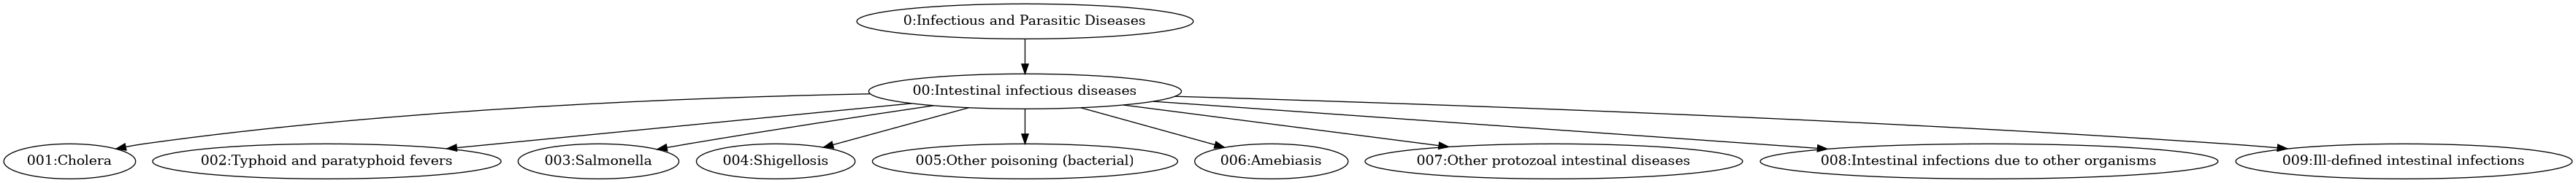

In [36]:
from anytree.exporter import DotExporter
from IPython.display import Image

def nodenamefunc(node):
    return f'{node.name}:{node.description}'

# draw tree
DotExporter(code_tree.find_by_name("0"),
            nodenamefunc=nodenamefunc,
            ).to_picture("images/image.png")

Image(filename='images/image.png')


### Get ICD9 Codes

In [48]:
# Dyamically Build Prompt

def get_options(tree, parent_code):
    children = tree.get_children(parent_code)
    options = []
    for child in children:
        options.append(f"{child.name}: {child.description}")
    
    return '\n'.join(options)

def build_prompt(tree, parent_code, note, categories):
    sys = """
    You are a medical expert. Your job is to classify notes into given categories. Think through your answer. Accuracy is VERY IMPORTANT to your job.
    Notes can be classified into one or more categories. Respond with a list of quoted string indeces of the categories the note belongs to. If there are no catefory options return an empty list.

    ### EXAMPLE ###
    Categories:
    0: Infectious and Parasitic Diseases
    1: Neoplasms
    2: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders
    Note: Patient has Tuberculosis and an Immunity Disorder
    Answer: ['0','3']
    ## END EXAMPLE ##
    """
    
    
    prompt = f"""
    Categories:\n{categories}
    Note: {note}
    Answer:
    """

    return sys, prompt

In [49]:
# Recursive? Walk tree and call aoai to get codes

def get_codes_for_note(parent_code, tree, note):
    
    categories = get_options(tree, parent_code)
    if not categories:
        return []
    
    sys, prompt = build_prompt(tree, parent_code, note, categories)
    codes = call_aoai(sys, prompt)
    print(f"Parent Code: {parent_code}")
    print(f"Codes: {codes}")

    if all(len(i) == 3 for i in codes):
        return codes
    else:
        list(map(functools.partial(get_codes_for_note, tree=tree, note=note), codes))
    

In [50]:
### TEST ###

codes = get_codes_for_note("root", code_tree, "Patient had Glanders and Leprosy")
print(codes)

INFO:httpx:HTTP Request: POST https://medcode-aoai-useast.openai.azure.com//openai/deployments/gpt4o-mini-deploy/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"


Parent Code: root
Codes: ['0']


INFO:httpx:HTTP Request: POST https://medcode-aoai-useast.openai.azure.com//openai/deployments/gpt4o-mini-deploy/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"


Parent Code: 0
Codes: ['03']


INFO:httpx:HTTP Request: POST https://medcode-aoai-useast.openai.azure.com//openai/deployments/gpt4o-mini-deploy/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"


Parent Code: 03
Codes: ['030', '031']
None


In [41]:
print(codes)

None


In [ ]:
for index, row in slim_df.iterrows():
    note = row['TEXT']
    get_codes_for_note("root", code_tree, note)
    break